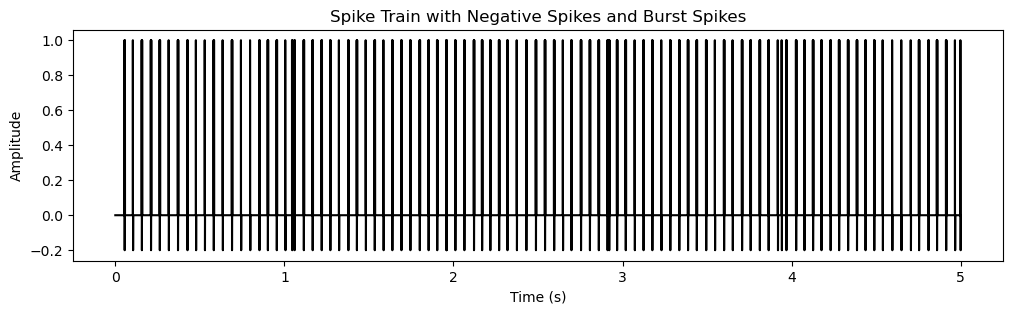

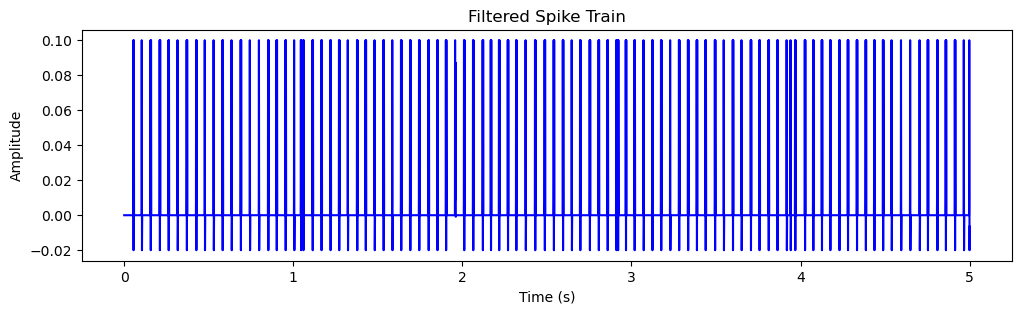

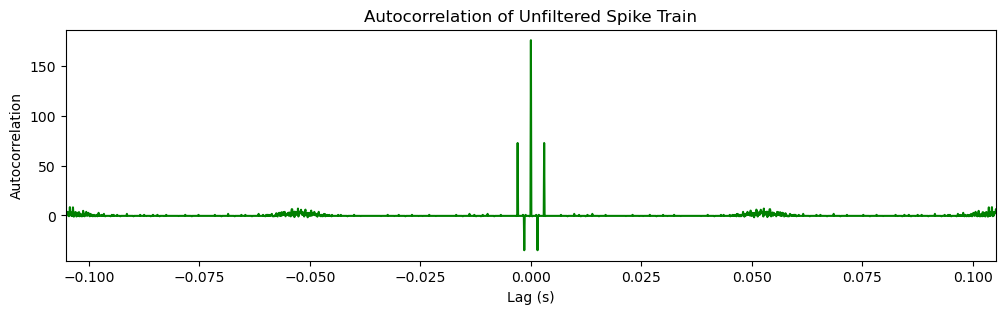

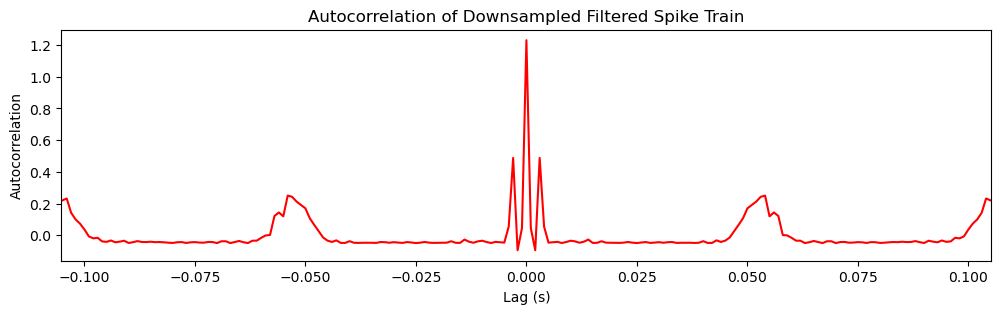

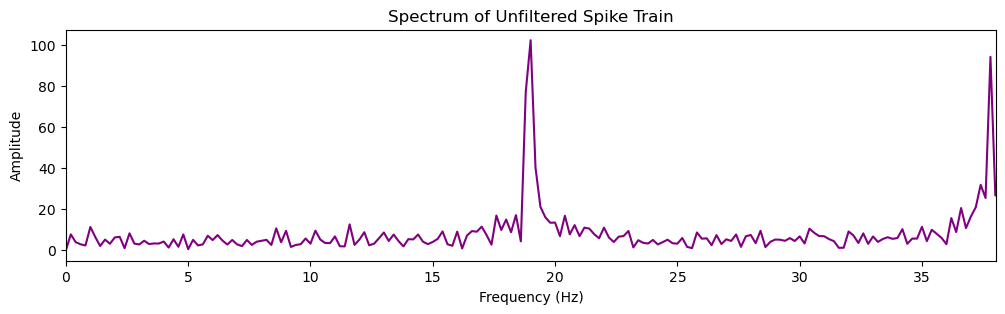

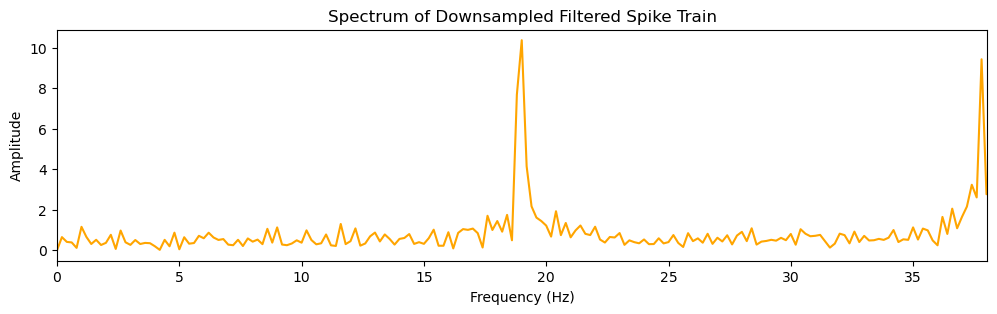

In [22]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.stats import truncnorm

# Parameters
# Total length of the signal in seconds
T_Tot_s = 5  

# Sampling rate in Hz
f_sample_Hz = 10000  

# Resolution for the spike generators in ms
r_gen_ms = 0.1  

# First spike generator parameters (Gaussian ISI distribution)
mu_ISI_1_ms = 52.6    # Mean ISI in ms
sigma_ISI_1_ms = 2.0  # Standard deviation of ISI in ms
nu_from_ISI_1_Hz = 1000. / (mu_ISI_1_ms)

# Second spike generator parameters (Gaussian ISI distribution)
mu_ISI_2_ms = 1000.    # Mean ISI in ms
sigma_ISI_2_ms = 100.  # Standard deviation of ISI in ms

# Gaussian kernel parameters for filtering
sigma_kernel_ms = 0.4  # Sigma of the Gaussian kernel in ms

# Downsampling parameter in ms
downsample_ms = 1.0    # Downsampling interval in ms

# New parameters for negative spikes
delay_ms = 1.5         # Delay after each spike to add a negative spike (in ms)
neg_ampl = -0.2        # Amplitude of the negative spike

# New parameters for burst spikes
p_burst = 0.7          # Probability of adding a burst spike after each spike
delay_burst_ms = 3.0   # Delay after each spike to add a burst spike (in ms)

# Convert parameters from ms to seconds
r_gen_s = r_gen_ms / 1000
mu_ISI_1_s = mu_ISI_1_ms / 1000
sigma_ISI_1_s = sigma_ISI_1_ms / 1000
mu_ISI_2_s = mu_ISI_2_ms / 1000
sigma_ISI_2_s = sigma_ISI_2_ms / 1000
sigma_kernel_s = sigma_kernel_ms / 1000
downsample_s = downsample_ms / 1000    # Downsampling interval in seconds
delay_s = delay_ms / 1000              # Delay for negative spikes in seconds
delay_burst_s = delay_burst_ms / 1000  # Delay for burst spikes in seconds

# Time vector
t = np.arange(0, T_Tot_s, 1 / f_sample_Hz)

# Function to generate spike times from ISIs
def generate_spike_train(mu_ISI, sigma_ISI, total_time):
    # Truncated normal distribution to avoid negative ISIs
    lower, upper = 0, np.inf
    if sigma_ISI > 0:
        a, b = (lower - mu_ISI) / sigma_ISI, (upper - mu_ISI) / sigma_ISI
        ISIs = truncnorm.rvs(a, b, loc=mu_ISI, scale=sigma_ISI, 
                             size=int(total_time / mu_ISI))
    else:
        ISIs = np.full(int(total_time / mu_ISI), mu_ISI)
    spike_times = np.cumsum(ISIs)
    spike_times = spike_times[spike_times < total_time]
    return spike_times

# Generate spike times for both spike trains
spike_times_1 = generate_spike_train(mu_ISI_1_s, sigma_ISI_1_s, T_Tot_s)
spike_times_2 = generate_spike_train(mu_ISI_2_s, sigma_ISI_2_s, T_Tot_s)

# Combine and sort spike times
all_spike_times = np.sort(np.concatenate((spike_times_1, spike_times_2)))

# Add burst spikes after each spike with probability p_burst
burst_spike_times = []
for spike_time in all_spike_times:
    if np.random.rand() < p_burst:
        burst_time = spike_time + delay_burst_s
        if burst_time < T_Tot_s:
            burst_spike_times.append(burst_time)

# Combine original and burst spike times
all_spike_times_with_burst = np.sort(np.concatenate((all_spike_times, burst_spike_times)))

# Create spike train signal
spike_train = np.zeros_like(t)
indices = np.searchsorted(t, all_spike_times_with_burst)
indices = indices[indices < len(spike_train)]  # Ensure indices are within bounds
spike_train[indices] = 1

# Add negative spikes after each original positive spike
# Calculate times for negative spikes
neg_spike_times = all_spike_times + delay_s
# Keep only negative spike times within the total duration
neg_spike_times = neg_spike_times[neg_spike_times < T_Tot_s]
# Find indices corresponding to negative spike times
neg_indices = np.searchsorted(t, neg_spike_times)
neg_indices = neg_indices[neg_indices < len(spike_train)]  # Ensure indices are within bounds
# Add negative spikes to the spike train
spike_train[neg_indices] += neg_ampl

# Plot the combined spike train with negative and burst spikes
plt.figure(figsize=(12, 3))
plt.plot(t, spike_train, color='black')
plt.title('Spike Train with Negative Spikes and Burst Spikes')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Create Gaussian kernel
kernel_size = int(6 * sigma_kernel_s * f_sample_Hz)
if kernel_size % 2 == 0:
    kernel_size += 1  # Ensure the kernel size is odd
kernel_time = np.linspace(-3 * sigma_kernel_s, 3 * sigma_kernel_s, kernel_size)
gaussian_kernel = np.exp(-0.5 * (kernel_time / sigma_kernel_s) ** 2)
gaussian_kernel /= np.sum(gaussian_kernel)  # Normalize the kernel

# Convolve the spike train with the Gaussian kernel
filtered_spike_train = convolve(spike_train, gaussian_kernel, mode='same')

# Plot the filtered spike train
plt.figure(figsize=(12, 3))
plt.plot(t, filtered_spike_train, color='blue')
plt.title('Filtered Spike Train')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Downsample the filtered signal
downsample_factor = int(round(downsample_ms * f_sample_Hz / 1000))
downsample_factor = max(1, downsample_factor)  # Ensure downsample factor is at least 1

filtered_spike_train_downsampled = filtered_spike_train[::downsample_factor]
t_downsampled = t[::downsample_factor]

# Adjusted sampling rate after downsampling
f_sample_down_Hz = f_sample_Hz / downsample_factor

# Compute autocorrelation of unfiltered spike train
auto_corr_unfiltered = np.correlate(spike_train - np.mean(spike_train), 
                                    spike_train - np.mean(spike_train), mode='full')
lags_unfiltered = np.arange(-len(spike_train) + 1, len(spike_train)) / f_sample_Hz

# Plot autocorrelation of unfiltered spike train
plt.figure(figsize=(12, 3))
plt.plot(lags_unfiltered, auto_corr_unfiltered, color='green')
plt.title('Autocorrelation of Unfiltered Spike Train')
plt.xlabel('Lag (s)')
plt.ylabel('Autocorrelation')
plt.xlim(-(mu_ISI_1_ms * 2) / 1000, (mu_ISI_1_ms * 2) / 1000)  # Zoom in around zero lag
plt.show()

# Compute autocorrelation of downsampled filtered spike train
auto_corr_filtered = np.correlate(filtered_spike_train_downsampled - np.mean(filtered_spike_train_downsampled), 
                                  filtered_spike_train_downsampled - np.mean(filtered_spike_train_downsampled), mode='full')
lags_filtered = np.arange(-len(filtered_spike_train_downsampled) + 1, len(filtered_spike_train_downsampled)) / f_sample_down_Hz

# Plot autocorrelation of downsampled filtered spike train
plt.figure(figsize=(12, 3))
plt.plot(lags_filtered, auto_corr_filtered, color='red')
plt.title('Autocorrelation of Downsampled Filtered Spike Train')
plt.xlabel('Lag (s)')
plt.ylabel('Autocorrelation')
plt.xlim(-(mu_ISI_1_ms * 2) / 1000, (mu_ISI_1_ms * 2) / 1000)  # Zoom in around zero lag
plt.show()

# Compute spectrum of unfiltered spike train
fft_unfiltered = np.fft.fft(spike_train - np.mean(spike_train))
freqs_unfiltered = np.fft.fftfreq(len(fft_unfiltered), d=1 / f_sample_Hz)

# Take the positive frequencies
positive_freqs_unfiltered = freqs_unfiltered[freqs_unfiltered >= 0]
positive_fft_unfiltered = np.abs(fft_unfiltered[freqs_unfiltered >= 0])

# Plot spectrum of unfiltered spike train
plt.figure(figsize=(12, 3))
plt.plot(positive_freqs_unfiltered, positive_fft_unfiltered, color='purple')
plt.title('Spectrum of Unfiltered Spike Train')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 2 * nu_from_ISI_1_Hz)  # Focus on lower frequencies
plt.show()

# Compute spectrum of downsampled filtered spike train
fft_filtered = np.fft.fft(filtered_spike_train_downsampled - np.mean(filtered_spike_train_downsampled))
freqs_filtered = np.fft.fftfreq(len(fft_filtered), d=1 / f_sample_down_Hz)

# Take the positive frequencies
positive_freqs_filtered = freqs_filtered[freqs_filtered >= 0]
positive_fft_filtered = np.abs(fft_filtered[freqs_filtered >= 0])

# Plot spectrum of downsampled filtered spike train
plt.figure(figsize=(12, 3))
plt.plot(positive_freqs_filtered, positive_fft_filtered, color='orange')
plt.title('Spectrum of Downsampled Filtered Spike Train')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 2 * nu_from_ISI_1_Hz)  # Focus on lower frequencies
plt.show()
